# Chapter 4: Dynamic Programming
**Dynamic programming (DP):** a collection of algorithms used to compute optimal policies given a **perfect model** of the environment (i.e. all environmental dynamics are known) as a Markov decision process (MDP). Though DP algorithms are limited by their assumptions and computational costs, they provide a foundation for reinforcement learning.

## Section 4.1: Policy Evaluation
This section presents *policy evaluation*, or the process of computing the state-value function, $v_{\pi}$, for an arbitrary policy, $\pi$. In the general, the formula for estimating the value, $v$, of some policy, $\pi$, for some state, $s$, is:

> $v_{\pi} = \sum_{a}\pi(a|s)\sum_{s',r}p(s',r | s,a)[r + \gamma v_{\pi}(s')]$

where: 
1. $\pi(a|s)$: the probability of taking action $a$ in state $s$ under policy $\pi$. 
2. $p(s',r | s,a)$: the probability of receiving reward $r$ given state $s$ and action $a$.
3. $r + \gamma v_{\pi}(s')$: the sum of expected reward and the previous value $v$ of policy $\pi$ multiplied by the decay function $\gamma$.

A unique solution is guaranteed insofar that $\gamma$ < 1 or eventual termination is guaranteed from all states under the policy $\pi$. 

#### Iterative Policy Evaluation
When full information about the environment is available, the value functions are computable through *iterative policy evaluation*. In iterative policy evaluation, the value functions are successively plugged into the equation above (beginning with arbitrary values). With each iteration, the value of the next successor state replaces the value of the previous state. This process is known as *full backup*. In fact, all DP algorithms are full backup algorithms because they are based on all possible next states rather than a sample next state. 

Formally, iterative policy evaluation convergences only in the limit, but in practice it must be halted short of this. Halting can occur when the difference in value between successive states is sufficiently small.

### Example 4.1: Gridworld
See textbook for details (pg. 82).

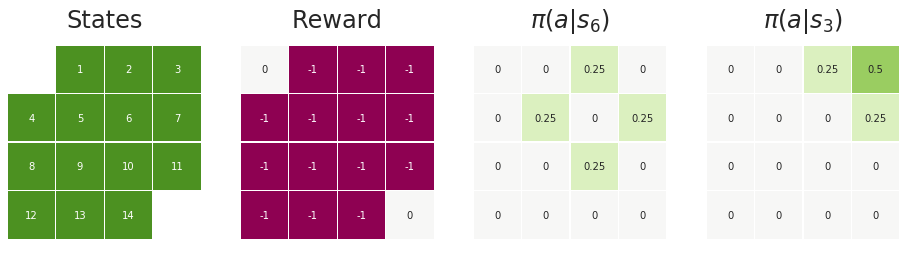

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=2)
%matplotlib inline

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define gridworld.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define grid dimensions.
N = M = 4

## Define indices.
indices = np.array(np.meshgrid(np.arange(N), np.arange(M))).reshape(2,N*M,order='F').T

## Define state labels.
states = np.arange(16).reshape(4,4).astype(float)
states[0,0] = states[-1,-1] = np.nan

## Define rewards.
rewards = np.ones((N,M)) * -1
rewards[0,0] = rewards[-1,-1] = 0

## Define transition probabilities.
transitions = np.zeros((N*M,N,M))
for state, trans in zip(indices[1:-1], transitions[1:-1]):
    
    for ix in state + np.array([[-1,0],[1,0],[0,-1],[0,1]]):
    
        if np.all( np.logical_and( ix >= 0, ix < 4 ) ): trans[ix[0], ix[1]] = 1
        else: trans[state[0], state[1]] += 1
                    
    trans /= 4
    
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

fig, axes = plt.subplots(1,4,figsize=(16,4),sharex=True,sharey=True)
titles = ['States', 'Reward', r'$\pi(a|s_6)$', r'$\pi(a|s_3)$']

for ax, arr, title in zip(axes, [states, rewards, transitions[6], transitions[3]], titles):
    
    sns.heatmap(arr, vmin=-1, vmax=0.8, center=0, linewidths=0.25, cmap='PiYG',
                annot=True, square=True, ax=ax, cbar=False)
    ax.set(xticklabels=[], yticklabels=[], title=title)

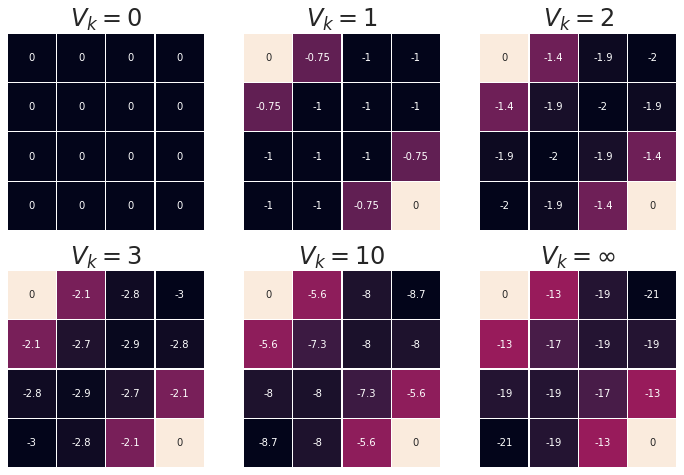

In [2]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Iterative policy evaluation.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

K = 1000
V = np.zeros((K, N, M))

for k in range(1,K):

    r = rewards + V[k-1]
    
    for state, trans in zip(indices, transitions):

        V[k,state[0],state[1]] = np.nansum(trans * r)
        
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Iterative policy evaluation.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

fig, axes = plt.subplots(2,3,figsize=(12,8),sharex=True,sharey=True)
K = [0, 1, 2, 3, 10, -1]

for ax, k in zip(axes.flatten(), K):
    
    if k < 0: title=r'$V_k = \infty$'
    else: title=r'$V_k = %s$' %k
    
    sns.heatmap(V[k], linewidths=0.25, annot=True, square=True, cbar=False, ax=ax)
    ax.set(xticklabels=[], yticklabels=[], title=title)

### Thoughts & Questions
1. Why is this not converging to what is shown in the textbook? Why is $V_k=1$ different in the textbook?
2. Why should this converge at all? Build an intuition for why $V_k=1000$ is approximately equivalent to $V_k=10000$.
3. Based on the example above, what are some of the fundamental limitations of the dynamic programming approach?

    * One obvious limitation is at the core of DP itself: full knowledge of the environment. This is an patently unrealistic requirement as virtually all of life's learning problems involve hidden environmental states that must be inferred. And, even then, these latent processes are noisy with the expected outcome occurring only some fraction of the time.
    * A second limitation is full backup, or that DP considers all possible next states rather than some subsample. This again seems like an unreasonable assumption. It may not be reasonable to assume that agents are aware of all of their options (let alone the consequent rewards of carrying out these actions). Even if an agent could recall all *relevant* actions (for certainly there are an infinity of possible responses to a scenario, with only a tiny fraction being goal-relevant), there is no reason to believe that they would. Sequential recall of potential options seems more realistic. Further, even if an agent does retrieve multiple options, there is no reason to assume that agents may evaluate the likely outcomes of all retrieved options. An agent may, when under time constraint, simply evaluate the first of the options that came to mind and, if it returns a sufficiently valuable outcome, pursue that without evaluating the remaining options. (Of course, it is likely there is some positive correlation between first retrieved and most successful.)

## Section 4.2: Policy Improvement
Continuing in situations with perfect knowledge of the environment, we can confidently state that if it is at any point advantageous to diverse from policy $\pi$ in state $s$ in order to select an alternative action $a_1$, then it can be assumed that it would be optimal to select $a_1$ every time we encounter state $s$. This statement can be formalized as the **policy improvement theorem**, which states that if for two policies $\pi$ and $\pi'$:

> $q_\pi (s, \pi'(s)) \geq v_\pi(s)$

then policy $\pi'$ must be as good as or better than $\pi$, such that:

> $v_{\pi'}(s) \geq v_\pi(s)$

This can be generalized into a **greedy policy** such that the selected action, for state $s$, is always the action $a$ that maximizes the expected value:

> $\pi'(s) = argmax( q_\pi(s,a) ) $

> $\pi'(s) = argmax \sum p(s', r|s, a)[r + \gamma v_\pi (s')] $

The process of making a new policy that improves on an original policy, by making it greedy with respect to the value function of the original policy, is called **policy improvement**. It should be noted that, in stochastic cases, if two or more policies tie in policy improvement then either option may be selected with some apportioned probability (insofar that the suboptimal actions are given zero probability). 

## Section 4.3: Policy Iteration
Following improvement, the value of a policy, $v_{\pi'}$, can be estimated, which can then be used for future policy improvement. This suggests a cycle of **policy evaluation** and **policy improvement**,  each iteration a strict improvement over the last, until optimality is reached. This process is known as **policy iteration** With finite MDP, policy iteration must converge to an optimal value and policy within a finite number of iterations. 

It should be noted that policy evaluation is, as demonstrated above, an iterative computation. Each iteration begins with the value function of the previous policy (this typically yields an increase in the speed of convergence). 

### Example 4.2: Jack's Car Rental

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=2)
%matplotlib inline

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Environment parameters.
latent_requests = [3, 4]
latent_returns =  [3, 2]

## Agent parameters.
available_cars = np.array([0,0])
exp_requests = np.random.poisson(latent_requests)
profit = 0

## Policy parameters.
actions = np.arange(-5,6)
values = np.zeros_like(states)
policy = np.zeros_like(states)

## Simulation parameters.
gamma = 0.9
n_steps = 100

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Simulations.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
np.random.seed(47404)

convergence = True
for n in range(n_steps):
    
    ## Returning cars.
    returns = np.random.poisson(latent_returns)
    available_cars += returns

    ## Requesting cars. Update expectations.
    requests = np.random.poisson(latent_requests)
    weights = (1 - 1/(1+n), 1/(1+n))
    exp_requests = np.average(np.vstack([exp_requests, requests]), weights=weights, axis=0)
    
    ## Transactions. 
    transactions = np.min(np.vstack([requests, available_cars]), axis=0)
    available_cars -= transactions
    profit += transactions.sum() * 10
    
    ## Policy improvement.
    if convergence:
        
        

SyntaxError: unexpected EOF while parsing (<ipython-input-3-c5dc9b3189f5>, line 55)